In [15]:
import os
import re
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import joblib
from rasterio.mask import geometry_mask
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, precision_recall_curve, plot_confusion_matrix
from imblearn.over_sampling import SMOTE

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\sklearn\metrics\__init__.py)

In [4]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Pair image and shapefile paths based on filenames
def pair_files(image_paths, shapefile_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        if not matching_shapefiles:
            print(f"No matching shapefile found for {image_path}")
            continue

        shapefile_path = matching_shapefiles[0]
        file_pairs[image_path] = shapefile_path
    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths)

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

# Extract features and labels for all image-shapefile pairs
def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, shapefile_path in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)
print(features, labels, image_name)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})


No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif
[[1187  980 1269 ... 1329 1416 1650]
 [1148  912 1212 ... 1240 1297 1612]
 [1131  856 1162 ... 1181 1355 1510]
 ...
 [1730 1870 1929 ... 2091 2276 2647]
 [1634 1851 1879 ... 2053 2281 2634]
 [1720 1904 1905 ... 2135 2316 2654]] ['walrus_mixed' 'walrus_mixed' 'walrus_mixed' ... 'freshwater'
 'freshwater' 'freshwater'] ['C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\buch_20230714_image.tif'
 ...
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images\\tor_20230902_image.tif'
 'C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_ima

In [5]:
# Custom function to ensure each island and rare classes are in the train set
def custom_train_test_split(df, test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df['encoded_labels']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df['encoded_labels'].values for cls in [le.transform(['walrus_pure'])[0], le.transform(['walrus_mixed'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df

# Split the data
train_df, test_df = custom_train_test_split(dataset)
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, train_df['encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, test_df['encoded_labels'].values

In [6]:
# Calculate and print the number of pixels for each class in the training and test datasets
def print_class_distribution(df, name):
    class_counts = df['encoded_labels'].value_counts()
    class_names = le.inverse_transform(class_counts.index)
    print(f"\n{name} Class Distribution:")
    for class_name, count in zip(class_names, class_counts):
        print(f"{class_name}: {count}")

# Calculate class distributions
print_class_distribution(train_df, "Training")
print_class_distribution(test_df, "Test")


Training Class Distribution:
ocean: 623431
ice: 240185
rock: 74284
freshwater: 32201
walrus_mixed: 657
walrus_pure: 38

Test Class Distribution:
ocean: 155857
ice: 60046
rock: 18572
freshwater: 8050
walrus_mixed: 165
walrus_pure: 10


In [7]:
# Calculate and print the number of pixels from each island in the test dataset
def print_island_distribution(df):
    islands = df['image_name'].apply(lambda x: extract_island_and_date(os.path.basename(x))[0])
    island_counts = islands.value_counts()
    print("\nTest Dataset Island Distribution:")
    for island, count in island_counts.items():
        print(f"{island}: {count}")

In [8]:
# Print image names used in the test data and the number of pixels from each island
def print_test_images_info(df):
    print("\nTest Dataset Image Names and Pixel Counts:")
    image_names = df['image_name'].unique()
    for image_name in image_names:
        image_pixel_count = (df['image_name'] == image_name).sum()
        print(f"Image: {os.path.basename(image_name)}, Pixels: {image_pixel_count}")

# Print island distribution and test images info
print_island_distribution(test_df)
print_test_images_info(test_df)


Test Dataset Island Distribution:
buch: 110509
tor: 54748
pal: 34007
sars: 30084
moff: 13352

Test Dataset Image Names and Pixel Counts:
Image: buch_20230714_image.tif, Pixels: 23561
Image: buch_20230720_image.tif, Pixels: 37126
Image: buch_20230731_image.tif, Pixels: 34912
Image: buch_20230923_image.tif, Pixels: 14910
Image: moff_20230717_image.tif, Pixels: 13352
Image: pal_20230714_image.tif, Pixels: 12674
Image: pal_20230720_image.tif, Pixels: 5710
Image: pal_20230726_image.tif, Pixels: 15623
Image: sars_20230714_image.tif, Pixels: 14871
Image: sars_20230803_image.tif, Pixels: 15213
Image: tor_20230801_image.tif, Pixels: 14920
Image: tor_20230824_image.tif, Pixels: 12097
Image: tor_20230901_image.tif, Pixels: 16752
Image: tor_20230902_image.tif, Pixels: 10979


In [9]:
# Visualize class distribution as a table and boxplot
def visualize_class_distribution(df):
    class_counts = df['encoded_labels'].value_counts()
    class_names = le.inverse_transform(class_counts.index)
    class_dist_df = pd.DataFrame({'Class': class_names, 'Count': class_counts.values})

    print("\nClass Distribution Table:")
    print(class_dist_df)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='labels', y='Count', data=class_dist_df)
    plt.title("Class Distribution")
    plt.show()

visualize_class_distribution(train_df)
visualize_class_distribution(test_df)



Class Distribution Table:
          Class   Count
0         ocean  623431
1           ice  240185
2          rock   74284
3    freshwater   32201
4  walrus_mixed     657
5   walrus_pure      38


ValueError: Could not interpret value `labels` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

SMOTE

In [11]:
# Split the data
train_df1, test_df1 = custom_train_test_split(dataset)

# Apply SMOTE to the training data
def apply_smote(train_df1):
    smote = SMOTE(random_state=42)
    X_train1 = train_df1.drop(columns=['labels', 'encoded_labels', 'image_name']).values
    y_train1 = train_df1['encoded_labels'].values
    X_train_smote, y_train_smote = smote.fit_resample(X_train1, y_train1)
    return X_train_smote, y_train_smote

X_train_smote, y_train_smote = apply_smote(train_df1)

X_test1, y_test1 = test_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, test_df['encoded_labels'].values

In [14]:
def print_class_distribution(labels, name):
    class_counts = pd.Series(labels).value_counts()
    class_names = le.inverse_transform(class_counts.index)
    print(f"\n{name} Class Distribution:")
    for class_name, count in zip(class_names, class_counts):
        print(f"{class_name}: {count}")
# Print class distributions for the original training data
print_class_distribution(train_df['encoded_labels'].values, "Original Training")


# Print class distributions for the SMOTE-applied training data
print_class_distribution(y_train_smote, "SMOTE-applied Training")

# Print class distributions for the test data
print_class_distribution(y_test1, "Test")



# Print class distributions for the SMOTE-applied training data
print_class_distribution(X_train_smote, y_train_smote, "SMOTE-applied Training")

# Print class distributions for the test data
print_class_distribution(X_test1, y_test1, "Test")


Original Training Class Distribution:
ocean: 623431
ice: 240185
rock: 74284
freshwater: 32201
walrus_mixed: 657
walrus_pure: 38

SMOTE-applied Training Class Distribution:
walrus_mixed: 623431
ocean: 623431
rock: 623431
freshwater: 623431
ice: 623431
walrus_pure: 623431

Test Class Distribution:
ocean: 155857
ice: 60046
rock: 18572
freshwater: 8050
walrus_mixed: 165
walrus_pure: 10


TypeError: print_class_distribution() takes 2 positional arguments but 3 were given

In [18]:
# Calculate and print the number of pixels from each island in the test dataset
def print_island_distribution(df):
    islands = df['image_name'].apply(lambda x: extract_island_and_date(os.path.basename(x))[0])
    island_counts = islands.value_counts()
    print("\nTest Dataset Island Distribution:")
    for island, count in island_counts.items():
        print(f"{island}: {count}")

# Print image names used in the test data and the number of pixels from each island
def print_test_images_info(df):
    print("\nTest Dataset Image Names and Pixel Counts:")
    image_names = df['image_name'].unique()
    for image_name in image_names:
        image_pixel_count = (df['image_name'] == image_name).sum()
        print(f"Image: {os.path.basename(image_name)}, Pixels: {image_pixel_count}")

# Print island distribution and test images info
print_island_distribution(test_df)
print_test_images_info(test_df)


Test Dataset Island Distribution:
buch: 110509
tor: 54748
pal: 34007
sars: 30084
moff: 13352

Test Dataset Image Names and Pixel Counts:
Image: buch_20230714_image.tif, Pixels: 23561
Image: buch_20230720_image.tif, Pixels: 37126
Image: buch_20230731_image.tif, Pixels: 34912
Image: buch_20230923_image.tif, Pixels: 14910
Image: moff_20230717_image.tif, Pixels: 13352
Image: pal_20230714_image.tif, Pixels: 12674
Image: pal_20230720_image.tif, Pixels: 5710
Image: pal_20230726_image.tif, Pixels: 15623
Image: sars_20230714_image.tif, Pixels: 14871
Image: sars_20230803_image.tif, Pixels: 15213
Image: tor_20230801_image.tif, Pixels: 14920
Image: tor_20230824_image.tif, Pixels: 12097
Image: tor_20230901_image.tif, Pixels: 16752
Image: tor_20230902_image.tif, Pixels: 10979



Class Distribution Table:
          Class   Count
0         ocean  623431
1           ice  240185
2          rock   74284
3    freshwater   32201
4  walrus_mixed     657
5   walrus_pure      38


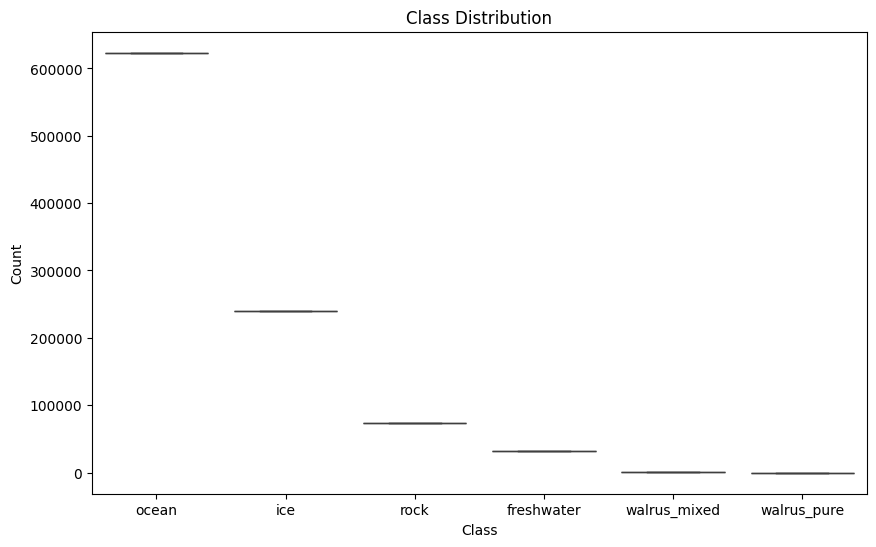

In [17]:
# Visualize class distribution as a table and boxplot
def visualize_class_distribution(df):
    class_counts = df['encoded_labels'].value_counts()
    class_names = le.inverse_transform(class_counts.index)
    class_dist_df = pd.DataFrame({'Class': class_names, 'Count': class_counts.values})

    print("\nClass Distribution Table:")
    print(class_dist_df)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Class', y='Count', data=class_dist_df)
    plt.title("Class Distribution")
    plt.show()

# Visualize original training data class distribution
visualize_class_distribution(train_df)


SMOTE Applied Training Data Class Distribution Table:
          Class   Count
0  walrus_mixed  623431
1         ocean  623431
2          rock  623431
3    freshwater  623431
4           ice  623431
5   walrus_pure  623431


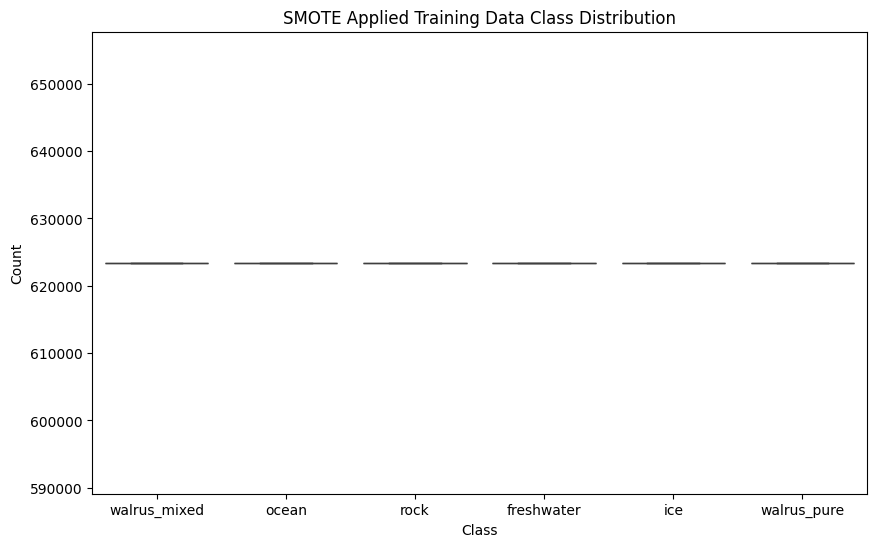

In [16]:
# Visualize SMOTE applied training data class distribution
smote_class_counts = pd.Series(y_train_smote).value_counts()
smote_class_names = le.inverse_transform(smote_class_counts.index)
smote_class_dist_df = pd.DataFrame({'Class': smote_class_names, 'Count': smote_class_counts.values})

print("\nSMOTE Applied Training Data Class Distribution Table:")
print(smote_class_dist_df)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Count', data=smote_class_dist_df)
plt.title("SMOTE Applied Training Data Class Distribution")
plt.show()

In [19]:
# Apply SMOTE to the training data and keep image names
def apply_smote_with_images(train_df):
    smote = SMOTE(random_state=42)
    X_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values
    y_train = train_df['encoded_labels'].values
    image_names = train_df['image_name'].values

    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Create a DataFrame for SMOTE applied data with image names
    smote_df = pd.DataFrame(X_train_smote, columns=train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).columns)
    smote_df['encoded_labels'] = y_train_smote
    smote_df['image_name'] = np.repeat(image_names, smote.sample_indices_.shape[0] // len(image_names))

    return smote_df

In [20]:
# Ensure each island and rare classes are in the train set
def custom_train_test_split(df, test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df['encoded_labels']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df['encoded_labels'].values for cls in [le.transform(['walrus_pure'])[0], le.transform(['walrus_mixed'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df


In [21]:
# Split the data
train_df, test_df = custom_train_test_split(dataset)
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, train_df['encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, test_df['encoded_labels'].values

# Print class distributions before SMOTE
print_class_distribution(train_df, "Training Before SMOTE")
print_class_distribution(test_df, "Test")

ValueError: 2

In [ ]:
# Apply SMOTE and get the augmented training DataFrame
train_df_smote = apply_smote_with_images(train_df)

# Print class distributions after SMOTE
print_class_distribution(train_df_smote, "Training After SMOTE")

In [ ]:
# Visualize class distributions using box plots
def plot_class_distribution(df, title):
    sns.boxplot(x='encoded_labels', y=df.groupby('encoded_labels').size(), data=df)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Pixels')
    plt.show()

plot_class_distribution(train_df, "Training Before SMOTE")
plot_class_distribution(train_df_smote, "Training After SMOTE")


In [ ]:
# Print class distribution by island after SMOTE
print_class_distribution_by_island(train_df_smote, "Training After SMOTE")

In [ ]:
# Train the Random Forest model using the SMOTE data
X_train_smote = train_df_smote.drop(columns=['encoded_labels', 'image_name']).values
y_train_smote = train_df_smote['encoded_labels'].values

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_smote, y_train_smote)

In [ ]:
# Save the model
model_filename = "RF_allislands_SMOTE.joblib"
joblib.dump(model, model_filename)

# Evaluate the model
y_pred = model.predict(X_test)

In [ ]:
# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

In [ ]:
# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Plot the Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [ ]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)

# Define a color map for the labels
label_colors = {
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()

In [ ]:
# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(pred


In [ ]:



# Apply SMOTE to the training data and keep image names
def apply_smote_with_images(train_df):
    smote = SMOTE(random_state=42)
    X_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values
    y_train = train_df['encoded_labels'].values
    image_names = train_df['image_name'].values

    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # Create a DataFrame for SMOTE applied data with image names
    smote_df = pd.DataFrame(X_train_smote, columns=train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).columns)
    smote_df['encoded_labels'] = y_train_smote
    smote_df['image_name'] = np.repeat(image_names, smote.sample_indices_.shape[0] // len(image_names))

    return smote_df

# Apply SMOTE and get the augmented training DataFrame
train_df_smote = apply_smote_with_images(train_df)

# Train the Random Forest model using the SMOTE data
X_train_smote = train_df_smote.drop(columns=['encoded_labels', 'image_name']).values
y_train_smote = train_df_smote['encoded_labels'].values

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_smote, y_train_smote)

# Save the model
model_filename = "RF_allislands_balanced.joblib"
joblib.dump(model, model_filename)

# Evaluate the model
y_pred = model.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot the confusion matrix
plot_confusion_matrix(model, X_test, y_test, display_labels=le.classes_, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot the Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)

# Define a color map for the labels
label_colors = {'ice': 'white', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'hotpink', 'freshwater': 'cyan', 'ocean': 'blue'}

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()

# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    plt.show()


In [ ]:
import glob
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import geometry_mask
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
import joblib
import matplotlib.colors as mcolors

In [ ]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    shapefile_path = matching_shapefiles[0]
    file_pairs[image_path] = shapefile_path

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

features = []
labels = []
image_name = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)
    image_name.append(img_name)

features = np.vstack(features)
labels = np.hstack(labels)
image_name = np.hstack(image_name)
print(features, labels, image_name)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({'Coast_blue': features[:, 0],
                        'Blue': features[:, 1],
                        'Green1': features[:, 2],
                        'Green': features[:, 3],
                        'Yellow': features[:, 4],
                        'Red': features[:, 5],
                        'Red_edge': features[:, 6],
                        'NIR': features[:, 7],
                        'labels': labels,
                        'encoded_labels': encoded_labels,
                        'image_name': image_name})

In [ ]:
# Custom function to ensure each island and rare classes are in the train set
def custom_train_test_split(df, test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df['encoded_labels']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df['encoded_labels'].values for cls in [le.transform(['walrus_pure'])[0], le.transform(['walrus_mixed'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df

# Split the data
train_df, test_df = custom_train_test_split(dataset)
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, train_df['encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, test_df['encoded_labels'].values

In [ ]:
# Calculate and print the number of pixels for each class in the training and test datasets
def print_class_distribution(df, name):
    class_counts = df['encoded_labels'].value_counts()
    class_names = le.inverse_transform(class_counts.index)
    print(f"\n{name} Class Distribution:")
    for class_name, count in zip(class_names, class_counts):
        print(f"{class_name}: {count}")

# Calculate class distributions
print_class_distribution(train_df, "Training")
print_class_distribution(test_df, "Test")


In [ ]:
# Calculate and print the number of pixels from each island in the test dataset
def print_island_distribution(df):
    islands = df['image_name'].apply(lambda x: extract_island_and_date(os.path.basename(x))[0])
    island_counts = islands.value_counts()
    print("\nTest Dataset Island Distribution:")
    for island, count in island_counts.items():
        print(f"{island}: {count}")

# Print image names used in the test data and the number of pixels from each island
def print_test_images_info(df):
    print("\nTest Dataset Image Names and Pixel Counts:")
    image_names = df['image_name'].unique()
    for image_name in image_names:
        image_pixel_count = (df['image_name'] == image_name).sum()
        print(f"Image: {os.path.basename(image_name)}, Pixels: {image_pixel_count}")

# Print island distribution and test images info
print_island_distribution(test_df)
print_test_images_info(test_df)


In [ ]:
# Classificaton Report 
import numpy as np
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=4))